In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/healthcare-diabetes/Healthcare-Diabetes.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report , accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

# Loading Dataset

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nanditapore/healthcare-diabetes")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/healthcare-diabetes


In [4]:
# Importing dataset, removing ID column
df = pd.read_csv('/kaggle/input/healthcare-diabetes/Healthcare-Diabetes.csv')

# Data Pre-processing and Exploratory Data Analysis (EDA)

In [5]:
# Checking the first 10 rows 
df.head(10)

,Id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1,6,148,72,35,0,33.6,0.627,50,1
1,2,1,85,66,29,0,26.6,0.351,31,0
2,3,8,183,64,0,0,23.3,0.672,32,1
3,4,1,89,66,23,94,28.1,0.167,21,0
4,5,0,137,40,35,168,43.1,2.288,33,1
5,6,5,116,74,0,0,25.6,0.201,30,0
6,7,3,78,50,32,88,31.0,0.248,26,1
7,8,10,115,0,0,0,35.3,0.134,29,0
8,9,2,197,70,45,543,30.5,0.158,53,1
9,10,8,125,96,0,0,0.0,0.232,54,1


Outcome 0 = have diabetes

Outcome 1 = dont have diabetes

In [6]:
# Display the structure of the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2768 entries, 0 to 2767
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Id                        2768 non-null   int64  
 1   Pregnancies               2768 non-null   int64  
 2   Glucose                   2768 non-null   int64  
 3   BloodPressure             2768 non-null   int64  
 4   SkinThickness             2768 non-null   int64  
 5   Insulin                   2768 non-null   int64  
 6   BMI                       2768 non-null   float64
 7   DiabetesPedigreeFunction  2768 non-null   float64
 8   Age                       2768 non-null   int64  
 9   Outcome                   2768 non-null   int64  
dtypes: float64(2), int64(8)
memory usage: 216.4 KB
None


In [7]:
df.shape

(2768, 10)

In [8]:
df.columns

Index(['Id', 'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
       'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [9]:
print(df.describe())

                Id  Pregnancies      Glucose  BloodPressure  SkinThickness  \
count  2768.000000  2768.000000  2768.000000    2768.000000    2768.000000   
mean   1384.500000     3.742775   121.102601      69.134393      20.824422   
std     799.197097     3.323801    32.036508      19.231438      16.059596   
min       1.000000     0.000000     0.000000       0.000000       0.000000   
25%     692.750000     1.000000    99.000000      62.000000       0.000000   
50%    1384.500000     3.000000   117.000000      72.000000      23.000000   
75%    2076.250000     6.000000   141.000000      80.000000      32.000000   
max    2768.000000    17.000000   199.000000     122.000000     110.000000   

           Insulin          BMI  DiabetesPedigreeFunction          Age  \
count  2768.000000  2768.000000               2768.000000  2768.000000   
mean     80.127890    32.137392                  0.471193    33.132225   
std     112.301933     8.076127                  0.325669    11.777230   
m

We can see that there are noisy values in our dataset

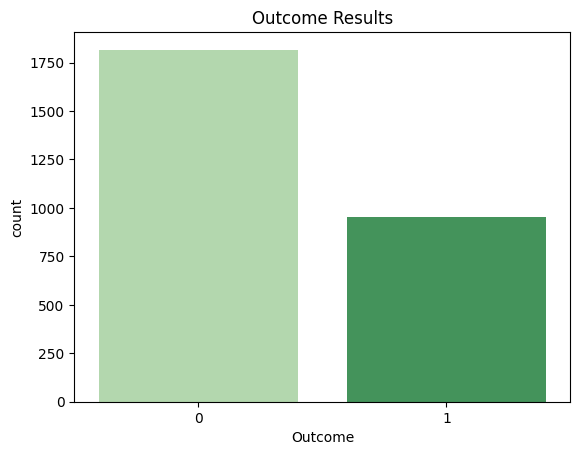

In [10]:
sns.countplot(x=df['Outcome'], palette="Greens")
plt.title('Outcome Results')
plt.show()

## Data Preprocessing 
preparing data for analysis and modelling

### Removing duplicates

In [11]:
# Checking if we had duplicates
print(df.duplicated().sum())

0


No duplicates in our data

### Handling Missing Data

In [12]:
# Check for missing (NaN) values in the dataset
print(df.isnull().sum())

Id                          0
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


No NULLs

### Handling Noisy Data

In [13]:
# Define the relevant ranges for each feature
ranges = {
    'Pregnancies': (0, 12),
    'Glucose': (70, 199),
    'BloodPressure': (60, 122),
    'SkinThickness': (10, 50),
    'BMI': (15, 60),
    'DiabetesPedigreeFunction': (0, 2),
    'Age': (21, 81)
}

# Replace out-of-range values with the mean of the column
for column, (min_val, max_val) in ranges.items():
    # Calculate the mean of the column
    column_mean = df[column].mean()
    
    # Replace values below the minimum or above the maximum with the mean
    df[column] = df[column].apply(lambda x: column_mean if x < min_val or x > max_val else x)

# Print the cleaned data size
print(f"Cleaned Data Size: {df.shape}")

Cleaned Data Size: (2768, 10)


In [14]:
# Removing first ID column as it doesnt have any impact on the dataset
df = df.drop(df.columns[0], axis=1)

## Data Visualisation
Visualising data to uncover patterns and insights

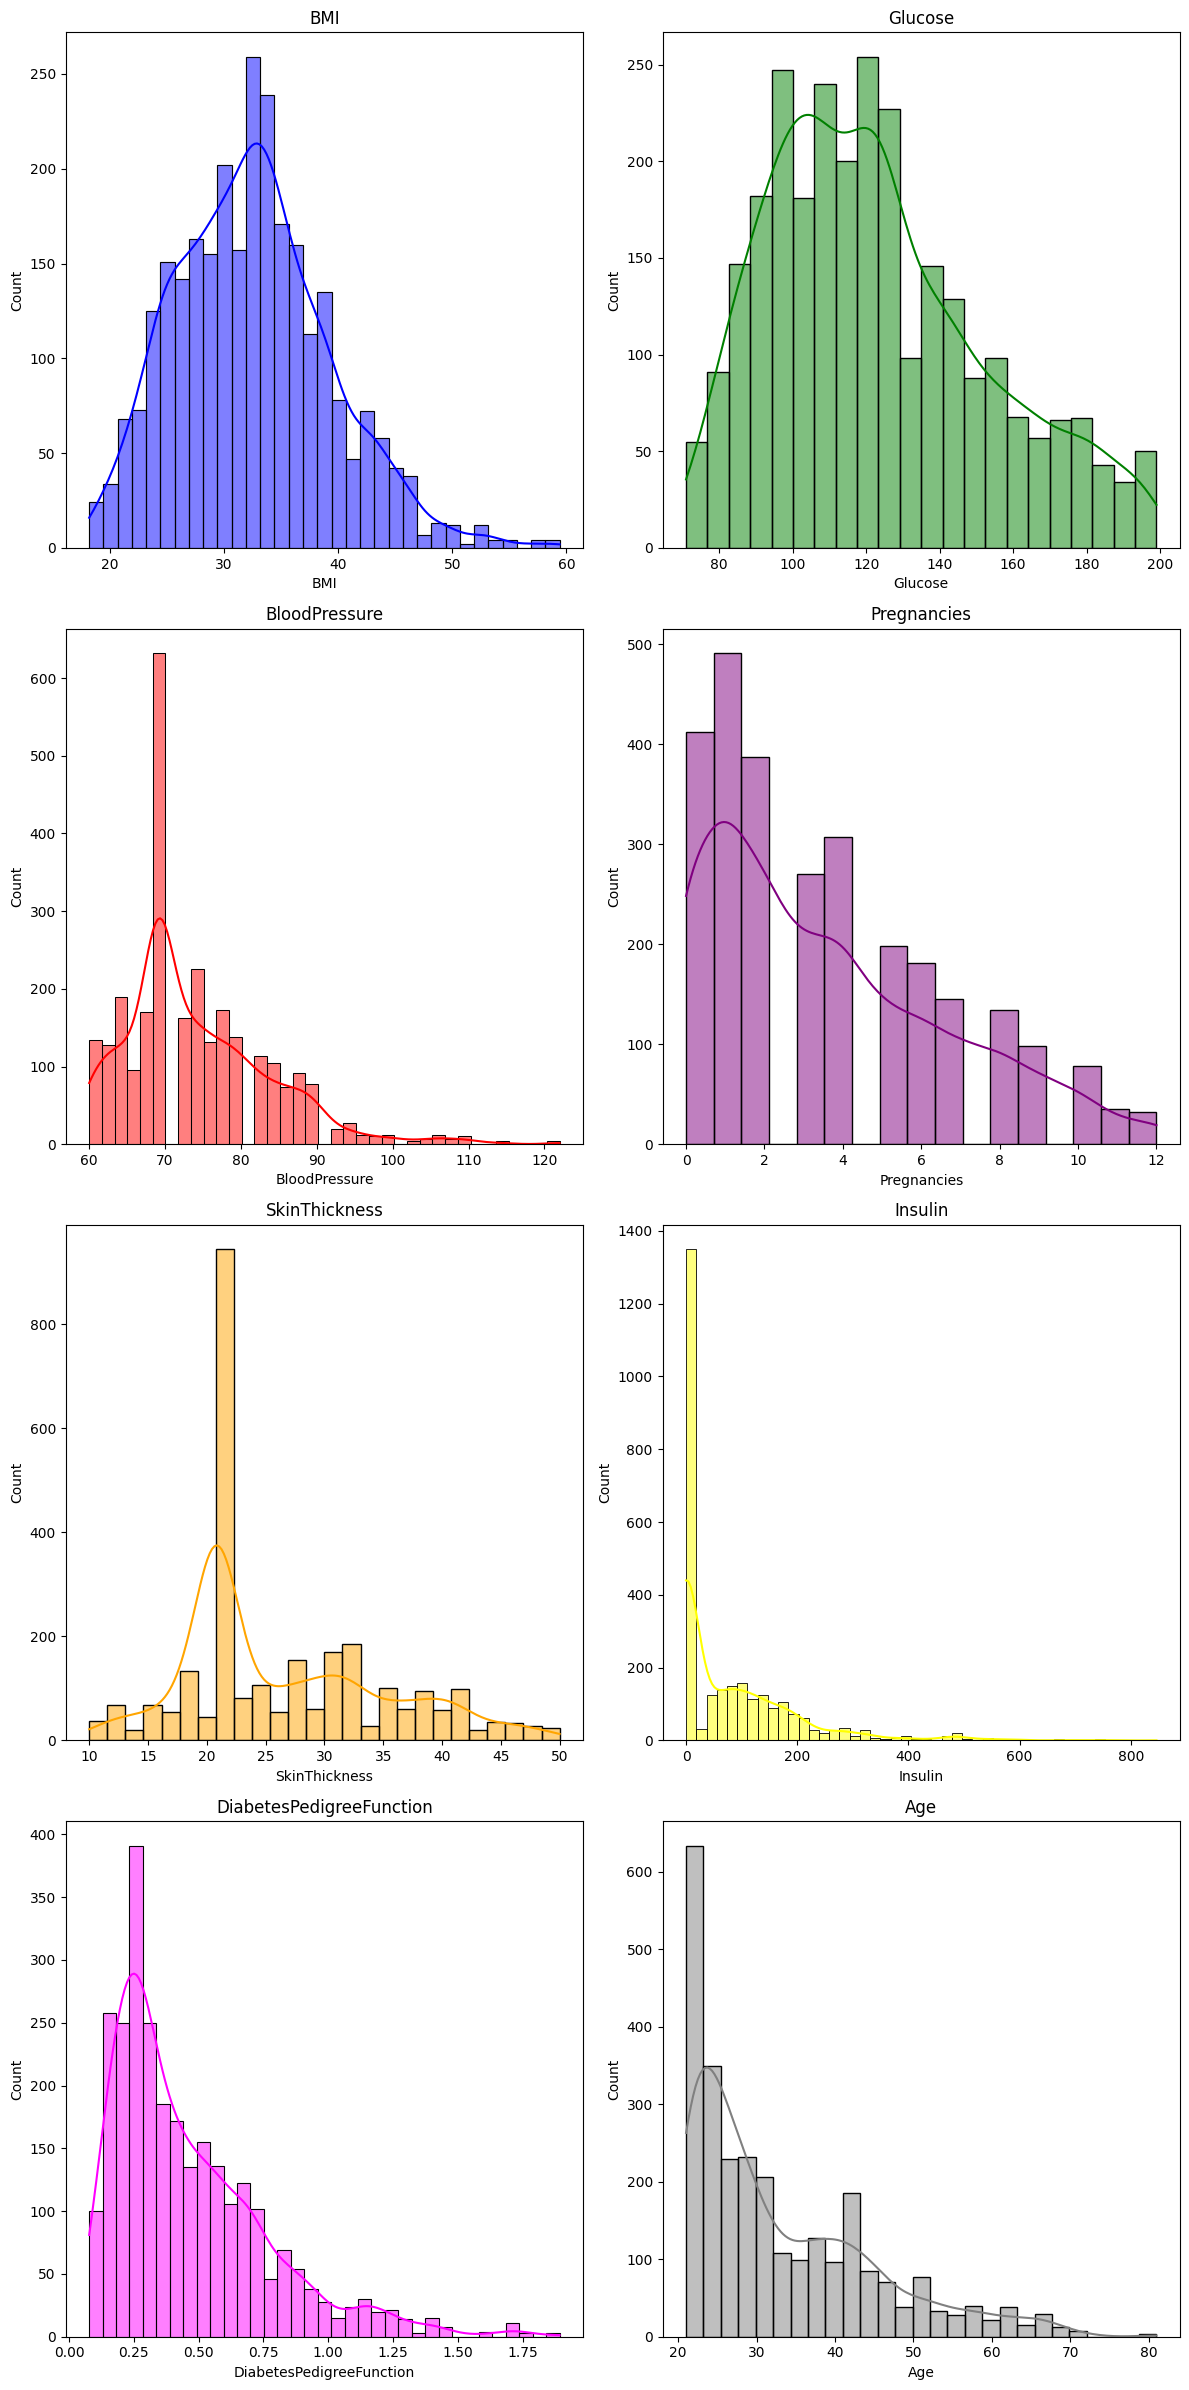

In [15]:
# List of numeric columns to plot
columns = [ 'BMI', 'Glucose', 'BloodPressure', 'Pregnancies', 'SkinThickness', 'Insulin', 'DiabetesPedigreeFunction', 'Age']

vibrant_palette = [
    "blue", "green", "red", "purple","orange","yellow", 
    "magenta", "grey", "black"
]

plt.figure(figsize=(12, 24))

for i, col in enumerate(columns):
    plt.subplot(4, 2, i+1)  
    sns.histplot(data=df, x=col, kde=True, color=vibrant_palette[i]
)  
    plt.title(col)  

plt.tight_layout()  
plt.show() 

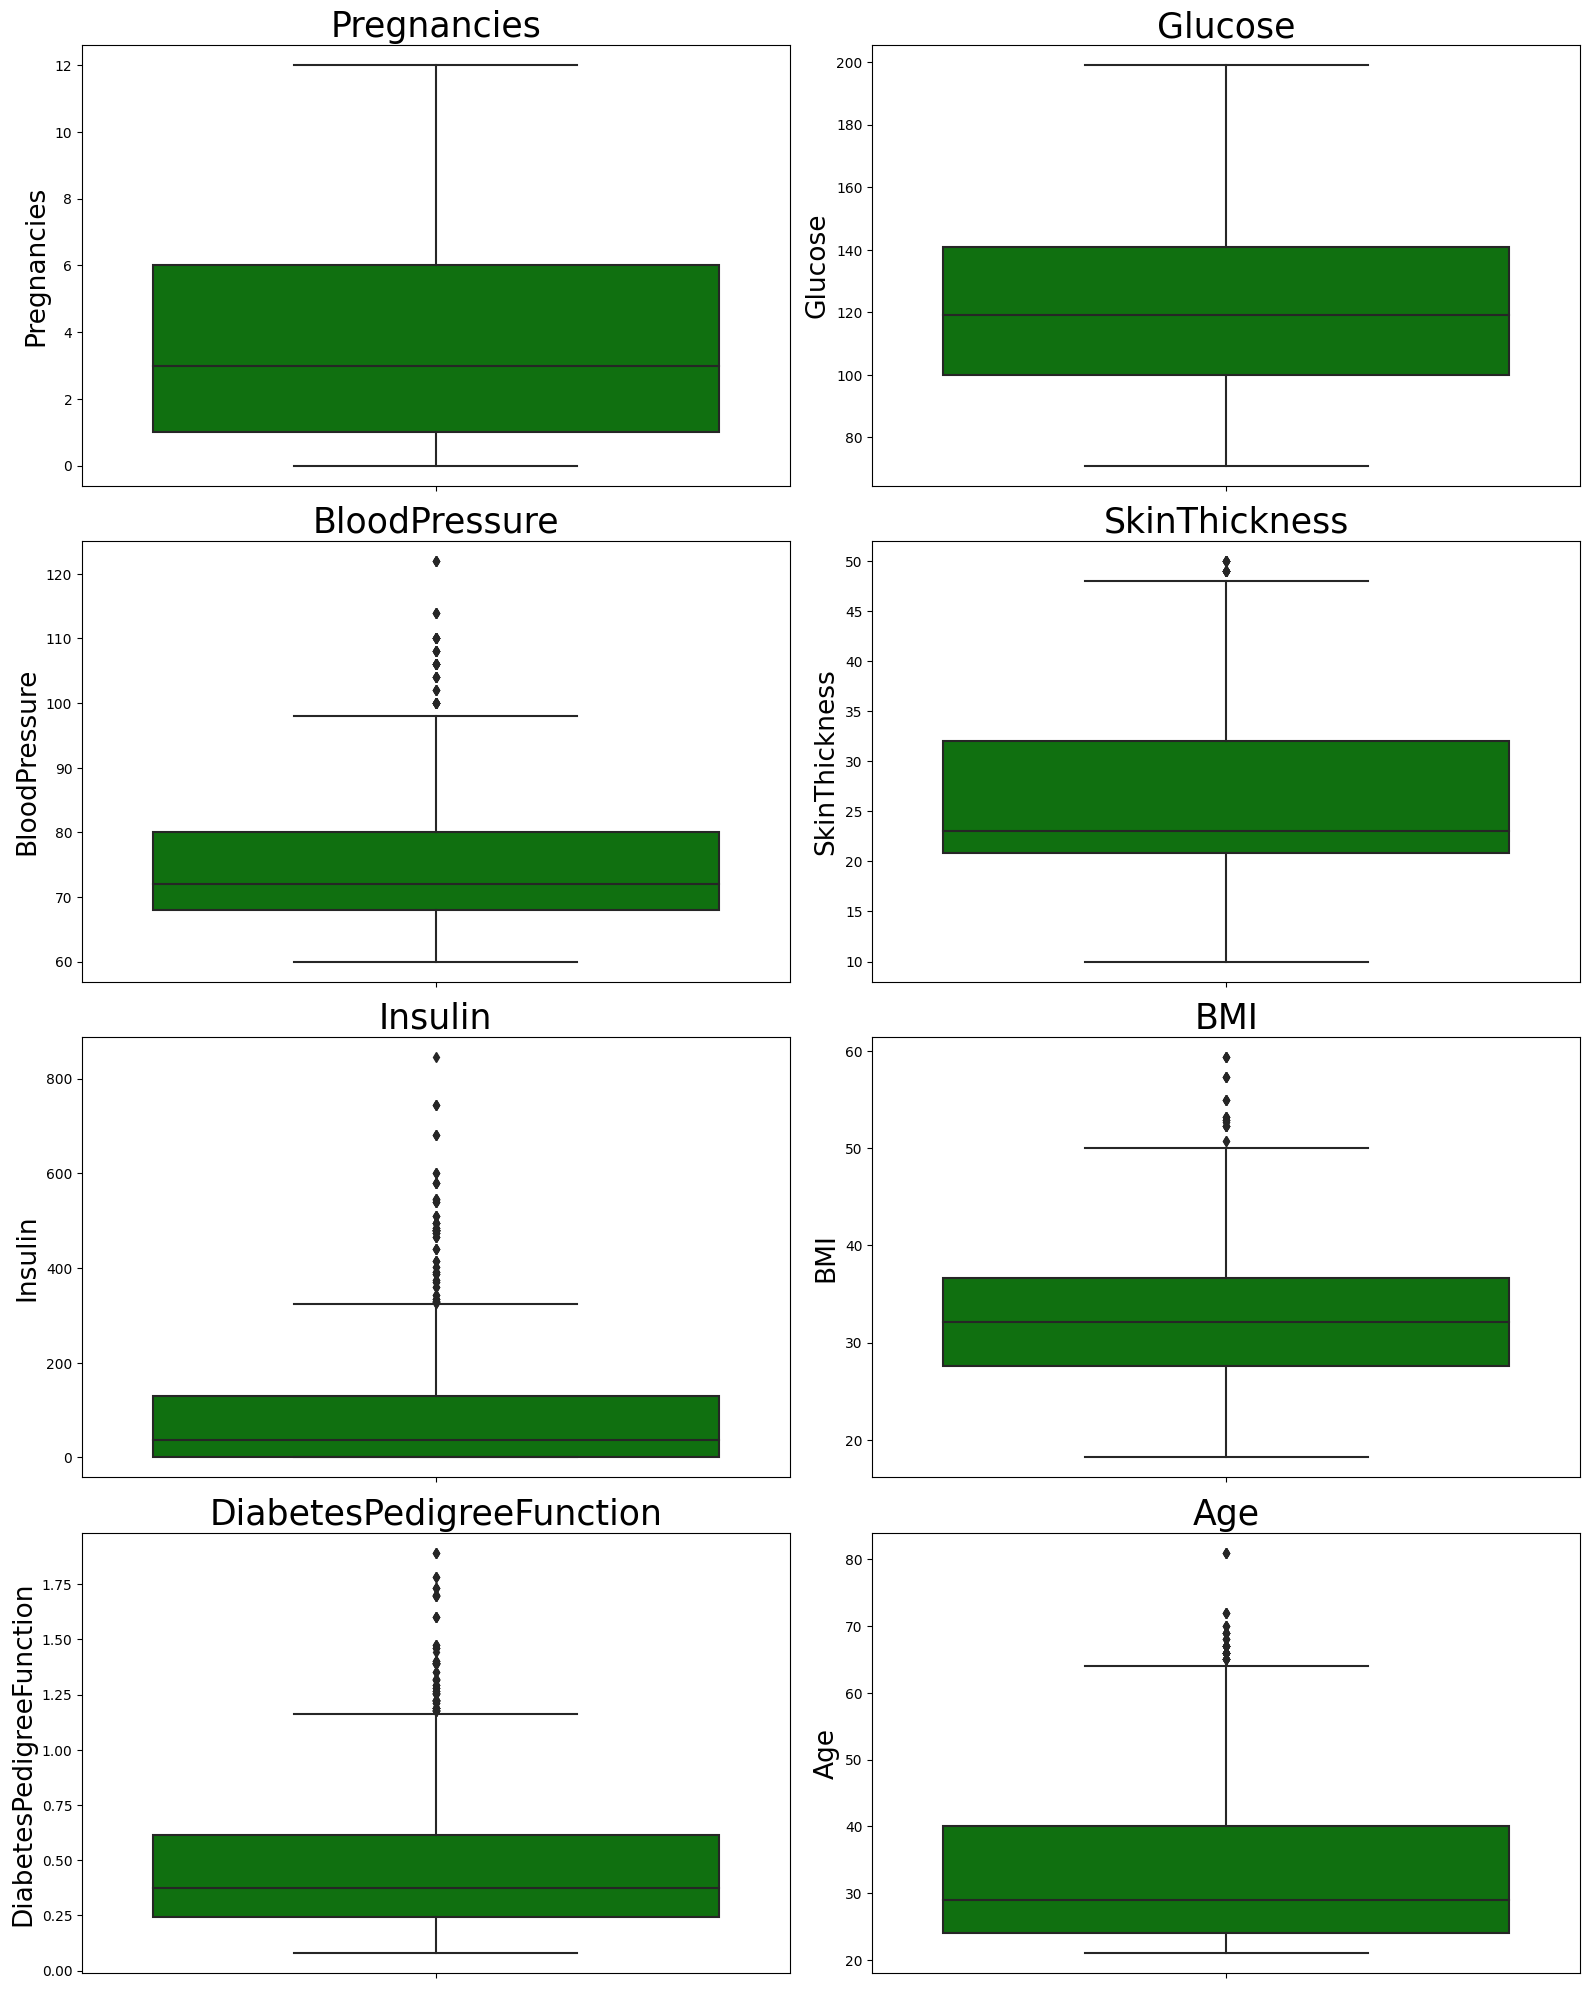

In [16]:
# List of numeric columns to plot
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Set up the figure size
plt.figure(figsize=(16, 20))  # Increase figure size to accommodate more subplots

# Loop through the columns and create boxplots
for i, col in enumerate(columns):
    plt.subplot(len(columns) // 2 + len(columns) % 2, 2, i+1)  # Create subplots in 2 columns
    sns.boxplot(data=df, y=col,  color='green')  # Create boxplot for each column
    plt.title(col, fontsize=25)  # Add a title for each plot
    plt.ylabel(col, fontsize=19 )

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Display the plots

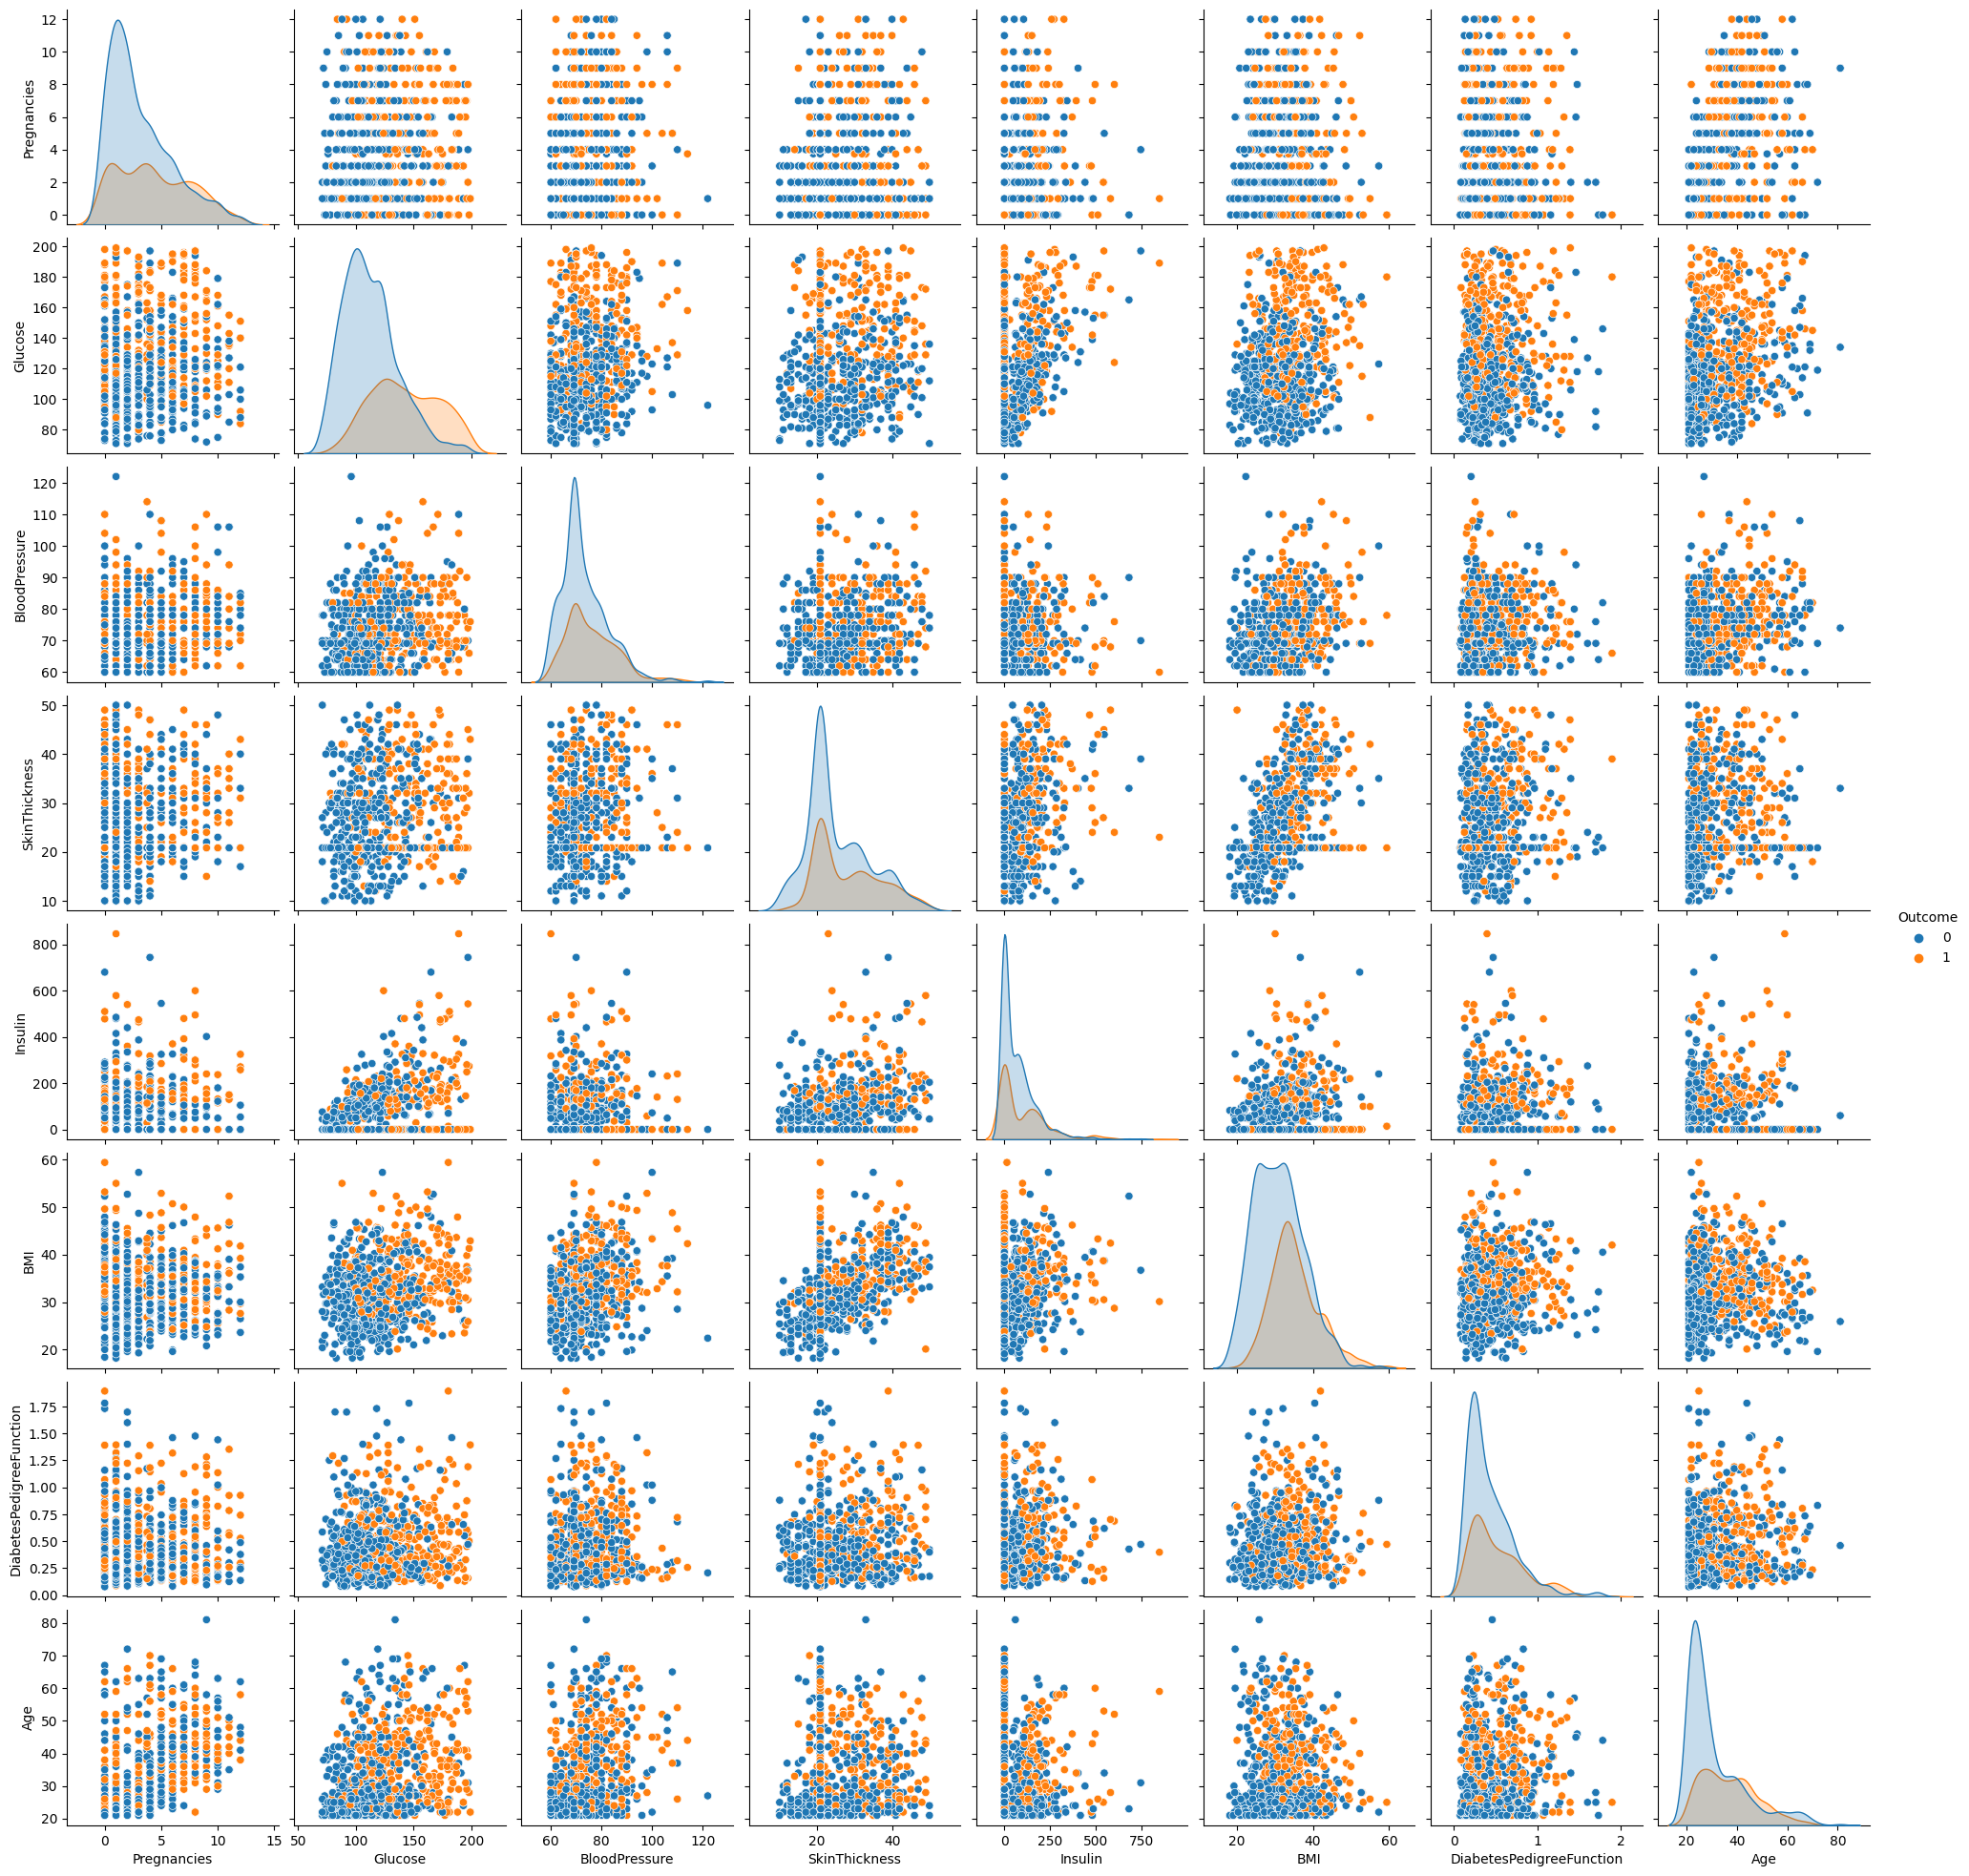

In [17]:
sns.pairplot(df, hue = "Outcome")

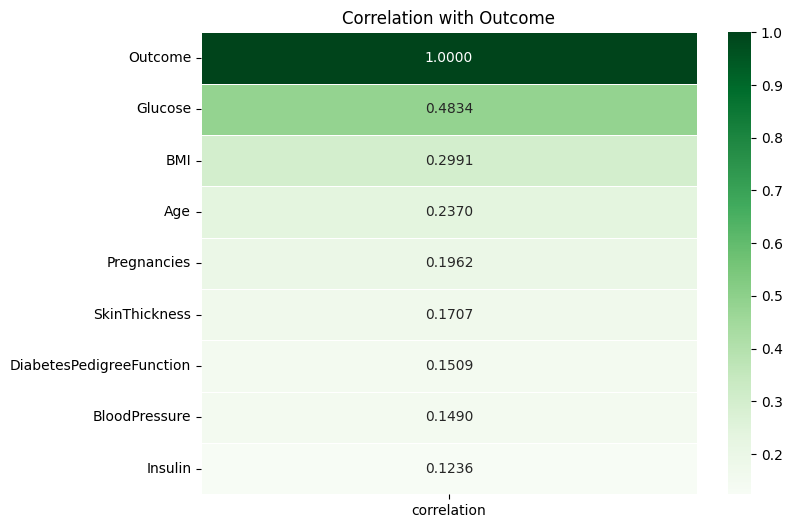

In [18]:
# Checking corrlation between data columns
correlation_with_outcome = df.corrwith(df['Outcome']).sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(correlation_with_outcome, columns=['correlation']), annot=True, cmap='Greens', fmt=".4f", linewidths=.5)

plt.title('Correlation with Outcome')
plt.show()

<Axes: >

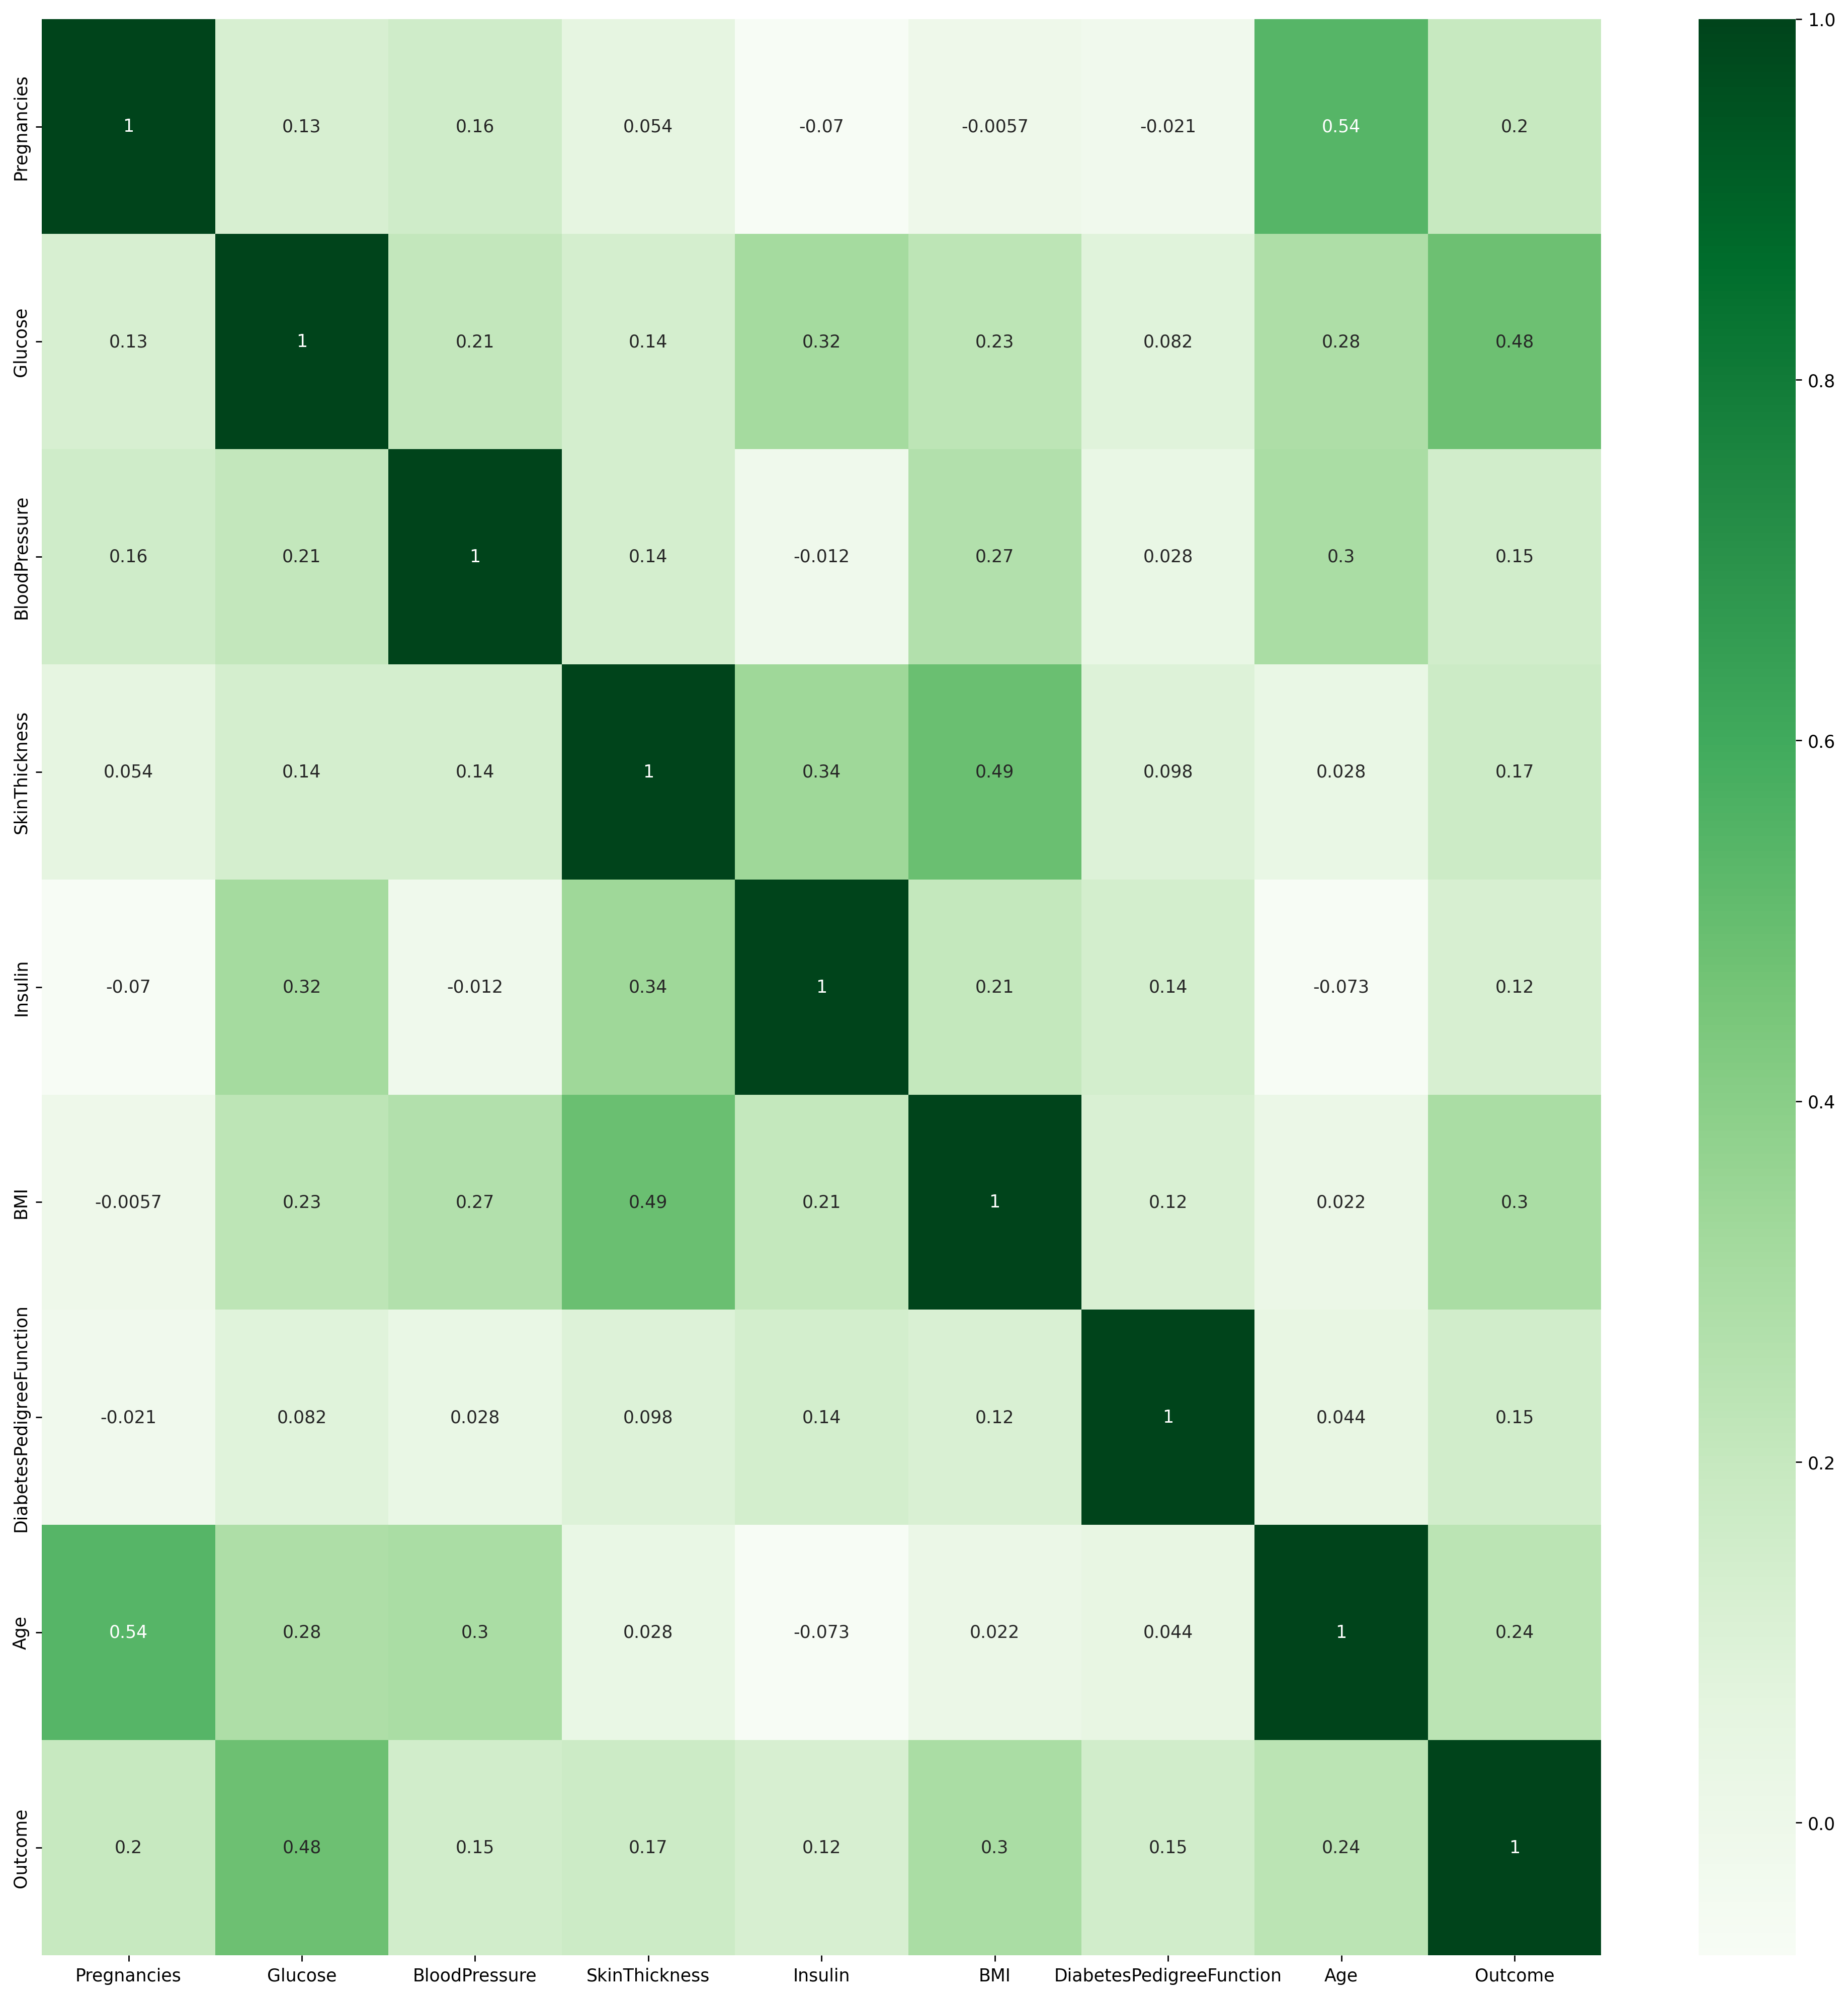

In [19]:
fig = plt.figure(figsize=(20,20), dpi=250)
sns.heatmap(df.corr(), cmap="Greens", annot=True)

Looking at the correlation between Outcome and other factors, we notice that patients with higher Glucose content, BMI values or older Age might have a higher chance at having Diabetes. Surprisingly, DiabetesPedigreeFunction does not have high correlation with Outcome.

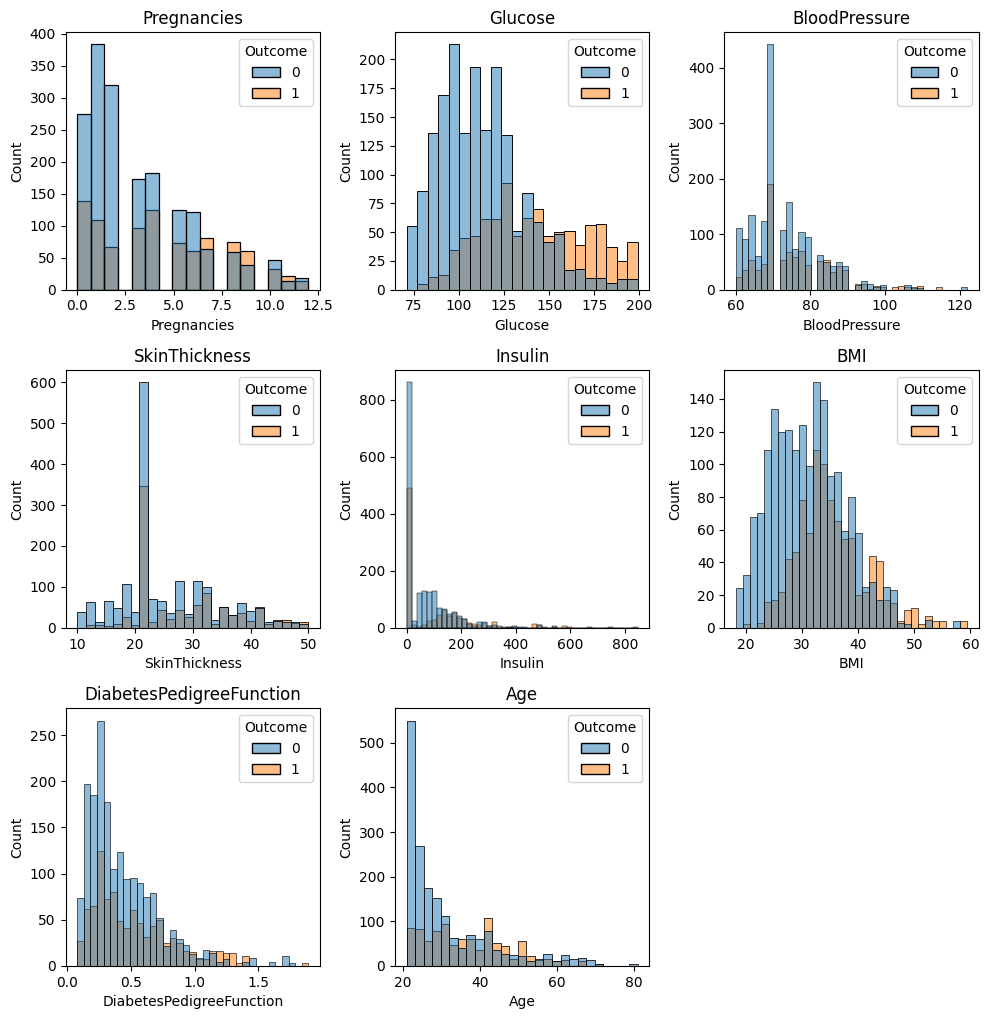

In [20]:
num_list=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']
fig = plt.figure(figsize=(10,20))

for i in range(len(num_list)):
    plt.subplot(6,3,i+1)
    plt.title(num_list[i])
    sns.histplot(data=df,x=df[num_list[i]],hue='Outcome', color="Greens")

plt.tight_layout()

### Removing Outliner

Pregnancies                    Axes(0.125,0.747241;0.133621x0.132759)
Glucose                     Axes(0.285345,0.747241;0.133621x0.132759)
BloodPressure                Axes(0.44569,0.747241;0.133621x0.132759)
SkinThickness               Axes(0.606034,0.747241;0.133621x0.132759)
Insulin                     Axes(0.766379,0.747241;0.133621x0.132759)
BMI                            Axes(0.125,0.587931;0.133621x0.132759)
DiabetesPedigreeFunction    Axes(0.285345,0.587931;0.133621x0.132759)
Age                          Axes(0.44569,0.587931;0.133621x0.132759)
Outcome                     Axes(0.606034,0.587931;0.133621x0.132759)
dtype: object

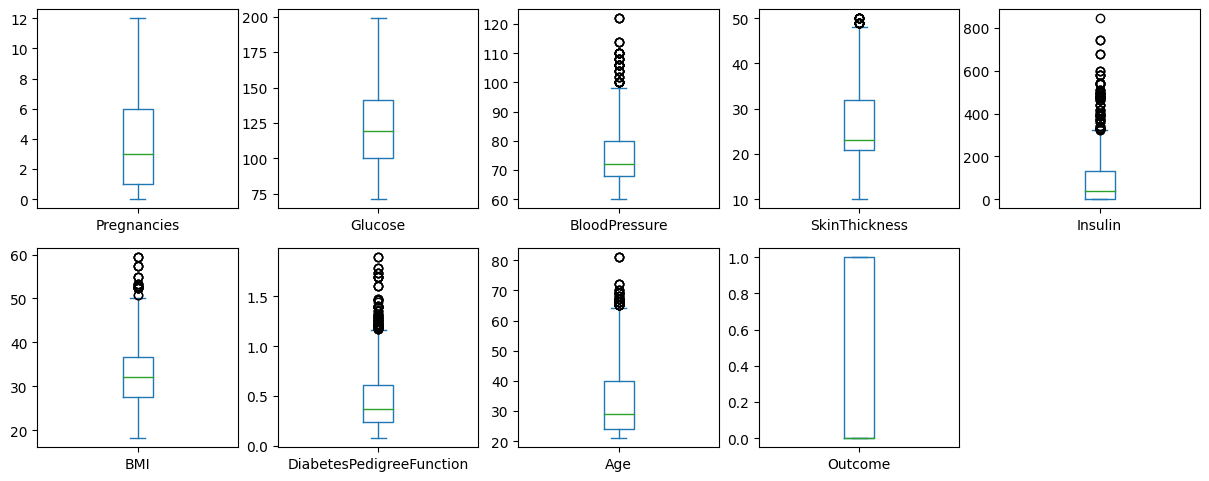

In [21]:
num_col = ['Pregnancies','Glucose','BloodPressure','SkinThickness'
           ,'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
no_outlier = df.copy()
for i in num_col:
    lower_limit = df[i].quantile(0.5)
    upper_limit = df[i].quantile(0.95)
    no_outlier[i] = no_outlier[i].clip(lower_limit, upper_limit)
df.plot(kind = "box" , subplots = True , figsize = (15,15) , layout = (5,5))


# Training the models

In [22]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']

In [23]:
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size=0.2 , random_state=17)

# Feature scalling

In [24]:
# Feature scalling
from sklearn.preprocessing import StandardScaler
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the testing data using the same scaler
X_test_scaled = scaler.transform(X_test)

In [25]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize the KNN model
knn = KNeighborsClassifier(n_neighbors=2)

# Train the model on the scaled training data
knn.fit(X_train_scaled, y_train)
# Evaluate the model on the scaled training and testing data
print("k-NN Accuracy:")
print("Train: ", knn.score(X_train_scaled, y_train), "Test: ", knn.score(X_test_scaled, y_test))

k-NN Accuracy:
Train:  0.99096657633243 Test:  0.9584837545126353


## Decision Tree

In [26]:
DT_model = DecisionTreeClassifier(random_state=20)
DT_model.fit(X_train , y_train)


DecisionTreeClassifier(random_state=20)

In [27]:
print("Train: ", DT_model.score(X_train , y_train),"Test: ", DT_model.score(X_test , y_test))

Train:  1.0 Test:  1.0


### Using dataset without outlier

In [28]:
X_no_outlier = no_outlier.drop('Outcome', axis=1)
y_no_outlier = no_outlier['Outcome']

In [29]:
X_train_n , X_test_n , y_train_n , y_test_n = train_test_split(X_no_outlier , y_no_outlier , test_size=0.3 , random_state=17)
DT_model.fit(X_train_n , y_train_n)
print("Train: ", DT_model.score(X_train_n , y_train_n),"Test: ", DT_model.score(X_test_n , y_test_n))

Train:  1.0 Test:  0.9903730445246691


In [30]:
DT_pred=DT_model.predict(X_test_n)
DT_acc = accuracy_score(y_test_n ,DT_pred )
print("Classification report: ")
print(classification_report(y_test_n , DT_pred))
print("Confusion matrix: ")
print(confusion_matrix(y_test_n,DT_pred))

Classification report: 
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       539
           1       0.98      0.99      0.99       292

    accuracy                           0.99       831
   macro avg       0.99      0.99      0.99       831
weighted avg       0.99      0.99      0.99       831

Confusion matrix: 
[[533   6]
 [  2 290]]


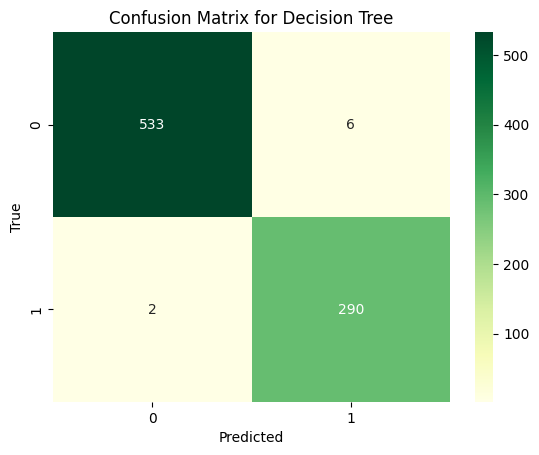

In [31]:
cm1 = confusion_matrix(y_test_n,DT_pred)
sns.heatmap(cm1,annot=True,cmap='YlGn',fmt='d')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Decision Tree")
plt.show()

## SVM

In [32]:

SVC = svm.SVC(kernel='rbf')
SVC.fit(X_train, y_train)
print("Train: ", SVC.score(X_train , y_train),"Test: ", SVC.score(X_test , y_test))

Train:  0.7664859981933153 Test:  0.776173285198556


In [33]:
svc_pred = SVC.predict(X_test)
svc_acc = accuracy_score(y_test , svc_pred)
print("Classification report: ")
print(classification_report(y_test , svc_pred))
print("Confusion matrix: ")
print(confusion_matrix(y_test,svc_pred))

Classification report: 
              precision    recall  f1-score   support

           0       0.78      0.91      0.84       358
           1       0.76      0.53      0.63       196

    accuracy                           0.78       554
   macro avg       0.77      0.72      0.73       554
weighted avg       0.77      0.78      0.76       554

Confusion matrix: 
[[326  32]
 [ 92 104]]


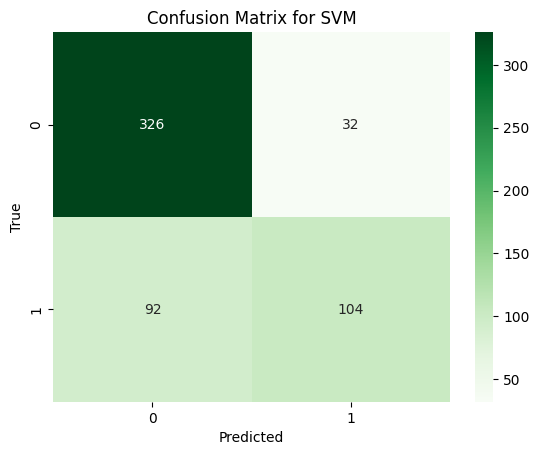

In [34]:
cm2 = confusion_matrix(y_test,svc_pred)
sns.heatmap(cm2,annot=True,cmap='Greens',fmt='d')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for SVM")
plt.show()

### Training SVM on scaled dataset

In [35]:
SVC = svm.SVC(kernel='rbf')

# Train the SVM model on the scaled training data
SVC.fit(X_train_scaled, y_train)

# Evaluate the model on the scaled training and testing data
print("Train: ", SVC.score(X_train_scaled, y_train), "Test: ", SVC.score(X_test_scaled, y_test))

Train:  0.8617886178861789 Test:  0.851985559566787


### Hyperparameter Tuning for SVM

The SVM model has two key hyperparameters that can significantly impact performance:

1. C (Regularization Parameter, that controls the trade-off between achieving a low training error and a low testing error. A smaller C encourages a larger margin, while a larger C aims for fewer misclassifications.
2. gamma (Kernel Coefficient), which defines how far the influence of a single training example reaches. A small gamma means a larger similarity radius, while a large gamma means a smaller radius.

We used GridSearchCV to find the best combination of C and gamma

In [36]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1, 10]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=5)

# Fit GridSearchCV on the scaled training data
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and accuracy
print("Best Parameters: ", grid_search.best_params_)
print("Best Cross-Validation Accuracy: ", grid_search.best_score_)

# Evaluate the best model on the scaled testing data
best_svm = grid_search.best_estimator_
print("Test Accuracy: ", best_svm.score(X_test_scaled, y_test))

Best Parameters:  {'C': 1, 'gamma': 10}
Best Cross-Validation Accuracy:  0.9747025116697138
Test Accuracy:  0.9891696750902527


SVM model performed well with the best parameters (C=1, gamma=10), achieving a test accuracy of 99.04%. This indicates that the model is highly effective for the dataset. 

In [37]:
# Predict on the scaled test data
svm_pred = best_svm.predict(X_test_scaled)
svm_acc=accuracy_score(y_test , svm_pred)
# Print classification report
print(classification_report(y_test, svm_pred))
print("Confusion matrix: ")
print(confusion_matrix(y_test,svm_pred))
# Evaluate the best model on the scaled training data to check for overfitting
train_accuracy = best_svm.score(X_train_scaled, y_train)
print("Training Accuracy: ", train_accuracy)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       358
           1       1.00      0.97      0.98       196

    accuracy                           0.99       554
   macro avg       0.99      0.98      0.99       554
weighted avg       0.99      0.99      0.99       554

Confusion matrix: 
[[358   0]
 [  6 190]]
Training Accuracy:  1.0


The classification report and training accuracy indicate that SVM model performs well.

## Random Forest

In [38]:
RF_model = RandomForestClassifier(n_estimators=400)
RF_model.fit(X_train , y_train)
print("Train: ", RF_model.score(X_train , y_train),"Test: ", RF_model.score(X_test , y_test))

Train:  1.0 Test:  0.9927797833935018


In [39]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=RF_model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Score:  0.9850954516204815


In [40]:
RF_pred = RF_model.predict(X_test)
RF_acc=accuracy_score(y_test , RF_pred)
print("Classification report: ")
print(classification_report(y_test , RF_pred))
print("Confusion matrix: ")
print(confusion_matrix(y_test,RF_pred))

Classification report: 
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       358
           1       0.98      0.99      0.99       196

    accuracy                           0.99       554
   macro avg       0.99      0.99      0.99       554
weighted avg       0.99      0.99      0.99       554

Confusion matrix: 
[[355   3]
 [  1 195]]


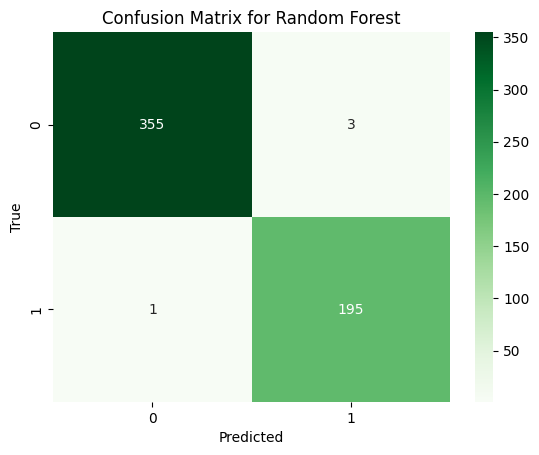

In [41]:
cm3 = confusion_matrix(y_test,RF_pred)
sns.heatmap(cm3,annot=True,cmap='Greens',fmt='d')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Random Forest")
plt.show()

## Naive Bayes

In [42]:
NB_model = GaussianNB()
NB_model.fit(X_train, y_train)
print("Train: ", NB_model.score(X_train , y_train),"Test: ", NB_model.score(X_test , y_test))

Train:  0.7402890695573623 Test:  0.796028880866426


Performance of the Naive Bayes model is lower compared to other models like Random Forest, SVC. Naive Bayes assumes that features are independent, which might not hold for your dataset. Also, it performs poorly if the data is not normally distributed (for Gaussian Naive Bayes), there are strong correlations between features, or the dataset is not balanced.

### Checking Correct Variant of Naive Bayes

In [43]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

# Try Multinomial Naive Bayes
nb_multinomial = MultinomialNB()
nb_multinomial.fit(X_train, y_train)
print("Multinomial Naive Bayes Test Accuracy: ", nb_multinomial.score(X_test, y_test))

# Try Bernoulli Naive Bayes
nb_bernoulli = BernoulliNB()
nb_bernoulli.fit(X_train, y_train)
print("Bernoulli Naive Bayes Test Accuracy: ", nb_bernoulli.score(X_test, y_test))

Multinomial Naive Bayes Test Accuracy:  0.5974729241877257
Bernoulli Naive Bayes Test Accuracy:  0.6462093862815884


Accuracy for Multinomial and Bernoulli is lower that Gaussian.

### Implementing feature scaling for Naive Bayes

In [44]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the testing data
X_test_scaled = scaler.transform(X_test)

# Train Naive Bayes on scaled data
nb = GaussianNB()
nb.fit(X_train_scaled, y_train)
print("Naive Bayes Test Accuracy (Scaled): ", nb.score(X_test_scaled, y_test))

Naive Bayes Test Accuracy (Scaled):  0.796028880866426


### Handling Class Imbalance

In [45]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Train Naive Bayes on balanced data
nb = GaussianNB()
nb.fit(X_train_balanced, y_train_balanced)
print("Naive Bayes Test Accuracy (Balanced): ", nb.score(X_test, y_test))

Naive Bayes Test Accuracy (Balanced):  0.7707581227436823


### Hyperparameter Tuning

In [46]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}

# Initialize GridSearchCV
grid_search = GridSearchCV(GaussianNB(), param_grid, cv=5)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and accuracy
print("Best Parameters: ", grid_search.best_params_)
print("Best Cross-Validation Accuracy: ", grid_search.best_score_)

# Evaluate the best model on the testing data
best_nb = grid_search.best_estimator_
print("Test Accuracy: ", best_nb.score(X_test, y_test))

Best Parameters:  {'var_smoothing': 1e-07}
Best Cross-Validation Accuracy:  0.7380417351868687
Test Accuracy:  0.796028880866426


In [47]:
NB_pred = NB_model.predict(X_test)
NB_acc=accuracy_score(y_test , NB_pred)
print("Classification report: ")
print(classification_report(y_test , NB_pred))
print("Confusion matrix: ")
print(confusion_matrix(y_test,NB_pred))

Classification report: 
              precision    recall  f1-score   support

           0       0.82      0.87      0.85       358
           1       0.73      0.66      0.70       196

    accuracy                           0.80       554
   macro avg       0.78      0.77      0.77       554
weighted avg       0.79      0.80      0.79       554

Confusion matrix: 
[[311  47]
 [ 66 130]]


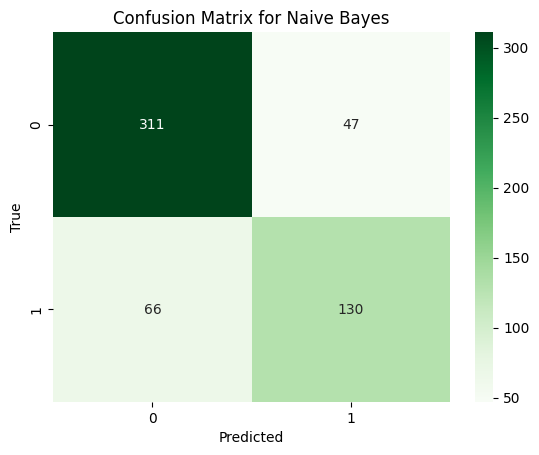

In [48]:
cm4 = confusion_matrix(y_test,NB_pred)
sns.heatmap(cm4,annot=True,cmap='Greens',fmt='d')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Naive Bayes")
plt.show()

## k-Nearest Neighbors

In [49]:
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train, y_train)
print("k-NN Accuracy:")
print("Train: ", knn.score(X_train , y_train),"Test: ", knn.score(X_test , y_test))

k-NN Accuracy:
Train:  0.8012646793134598 Test:  0.7653429602888087


### Hyperparameter tuning for KNN

To further improve KNN model, I tuned the hyperparameters, such as the number of neighbours (n_neighbors), distance metric,and used weighted KNN, where closer neighbours have more influence on the prediction.

In [50]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Define the parameter grid
param_grid = {'n_neighbors': range(1, 20)}

# Initialize GridSearchCV
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)

# Fit GridSearchCV on the scaled training data
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and accuracy
print("Best Parameters: ", grid_search.best_params_)
print("Best Cross-Validation Accuracy: ", grid_search.best_score_)

# Evaluate the best model on the scaled testing data
best_knn = grid_search.best_estimator_
print("Test Accuracy: ", best_knn.score(X_test_scaled, y_test))

# Access the cv_results_ attribute
cv_results = grid_search.cv_results_

# Create a list of (mean_test_score, params) tuples
results = list(zip(cv_results['mean_test_score'], cv_results['params']))

# Sort the results by mean_test_score in descending order
results_sorted = sorted(results, key=lambda x: x[0], reverse=True)

# Print the second-best result
second_best_score, second_best_params = results_sorted[1]
print("\nSecond-Best Parameters: ", second_best_params)
print("Second-Best Cross-Validation Accuracy: ", second_best_score)

Best Parameters:  {'n_neighbors': 1}
Best Cross-Validation Accuracy:  0.9742520658202507
Test Accuracy:  0.9963898916967509

Second-Best Parameters:  {'n_neighbors': 2}
Second-Best Cross-Validation Accuracy:  0.9281829974566664


In [51]:
# Check training and test accuracy for n_neighbors=1
knn_1 = KNeighborsClassifier(n_neighbors=1)
knn_1.fit(X_train_scaled, y_train)
print("Training Accuracy (n_neighbors=1): ", knn_1.score(X_train_scaled, y_train))
print("Test Accuracy (n_neighbors=1): ", knn_1.score(X_test_scaled, y_test))

# Try n_neighbors=2
knn_2 = KNeighborsClassifier(n_neighbors=2)
knn_2.fit(X_train_scaled, y_train)
print("Training Accuracy (n_neighbors=2): ", knn_2.score(X_train_scaled, y_train))
print("Test Accuracy (n_neighbors=2): ", knn_2.score(X_test_scaled, y_test))

# Weighted KNN with n_neighbors=1
knn_weighted_1 = KNeighborsClassifier(n_neighbors=1, weights='distance')
knn_weighted_1.fit(X_train_scaled, y_train)
print("Weighted KNN Training Accuracy (n_neighbors=1): ", knn_weighted_1.score(X_train_scaled, y_train))
print("Weighted KNN Test Accuracy (n_neighbors=1): ", knn_weighted_1.score(X_test_scaled, y_test))

# Weighted KNN with n_neighbors=2
knn_weighted_2 = KNeighborsClassifier(n_neighbors=2, weights='distance')
knn_weighted_2.fit(X_train_scaled, y_train)
print("Weighted KNN Training Accuracy (n_neighbors=2): ", knn_weighted_2.score(X_train_scaled, y_train))
print("Weighted KNN Test Accuracy (n_neighbors=2): ", knn_weighted_2.score(X_test_scaled, y_test))
print("")

Training Accuracy (n_neighbors=1):  1.0
Test Accuracy (n_neighbors=1):  0.9963898916967509
Training Accuracy (n_neighbors=2):  0.9905149051490515
Test Accuracy (n_neighbors=2):  0.9548736462093863
Weighted KNN Training Accuracy (n_neighbors=1):  1.0
Weighted KNN Test Accuracy (n_neighbors=1):  0.9963898916967509
Weighted KNN Training Accuracy (n_neighbors=2):  1.0
Weighted KNN Test Accuracy (n_neighbors=2):  0.9963898916967509



In [52]:
from sklearn.metrics import classification_report

# Predict on the test set
KNN_pred = knn_1.predict(X_test_scaled)
KNN_pred_2 = knn_2.predict(X_test_scaled)
KNN_pred_w_1 = knn_weighted_1.predict(X_test_scaled)
KNN_pred_w_2 = knn_weighted_2.predict(X_test_scaled)
# Print classification report
print("Classification report for n_neighbors=1")
print(classification_report(y_test, KNN_pred))
print("Classification report for n_neighbors=2")
print(classification_report(y_test, KNN_pred_2))
print("Classification report for weighted KNN with n_neighbors=1")
print(classification_report(y_test, KNN_pred_w_1))
print("Classification report for weighted KNN with n_neighbors=2")
print(classification_report(y_test, KNN_pred_w_2))

Classification report for n_neighbors=1
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       358
           1       1.00      0.99      0.99       196

    accuracy                           1.00       554
   macro avg       1.00      0.99      1.00       554
weighted avg       1.00      1.00      1.00       554

Classification report for n_neighbors=2
              precision    recall  f1-score   support

           0       0.93      1.00      0.97       358
           1       1.00      0.87      0.93       196

    accuracy                           0.95       554
   macro avg       0.97      0.94      0.95       554
weighted avg       0.96      0.95      0.95       554

Classification report for weighted KNN with n_neighbors=1
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       358
           1       1.00      0.99      0.99       196

    accuracy                           1.00 

For n_neighbors=1 the model is overfitting because the training accuracy is 100%, but the test accuracy is slightly lower.
For n_neighbors=2 i got good precision and recall for class 0, but recall for class 1 drops to 84%.

The weighted KNN with n_neighbors=2 is the best choice because it achieves high accuracy on both the training and test sets, avoids overfitting, and performs well across all evaluation metrics.

In [53]:
print("Classification report: ")
print(classification_report(y_test, KNN_pred_w_2))
print("Confusion matrix: ")
print(confusion_matrix(y_test,KNN_pred_w_2))

Classification report: 
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       358
           1       1.00      0.99      0.99       196

    accuracy                           1.00       554
   macro avg       1.00      0.99      1.00       554
weighted avg       1.00      1.00      1.00       554

Confusion matrix: 
[[358   0]
 [  2 194]]


In [54]:
# Calculate KKN accuracy
KNN_acc=accuracy_score(y_test , KNN_pred_w_2)

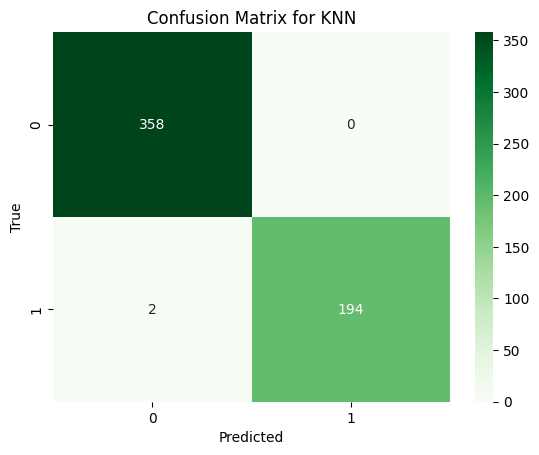

In [55]:
cm5 = confusion_matrix(y_test,KNN_pred_w_2)
sns.heatmap(cm5,annot=True,cmap='Greens',fmt='d')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for KNN")
plt.show()

# Model scores

In [56]:
models=pd.DataFrame({
    'models':['Decision_Tree','SVC','Random_Forest', 'Naive_Bayes', 'KNN'],
    'scores':[DT_acc,svm_acc,RF_acc, NB_acc, KNN_acc]})
models.sort_values(by='scores',ascending=False)

,models,scores
4,KNN,0.996390
2,Random_Forest,0.992780
0,Decision_Tree,0.990373
1,SVC,0.989170
3,Naive_Bayes,0.796029


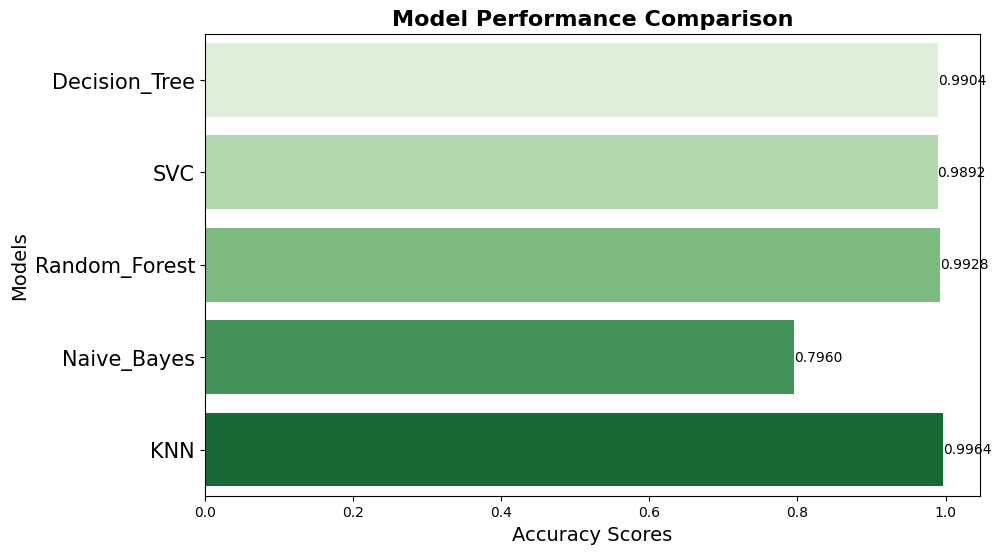

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the horizontal bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='scores', y='models', data=models, palette='Greens', orient='h')

# Add labels and title
plt.xlabel('Accuracy Scores', fontsize=14)
plt.ylabel('Models', fontsize=14)
plt.title('Model Performance Comparison', fontsize=16, fontweight='bold')
plt.yticks(fontsize=15)

# Add the accuracy values on the bars
for i, score in enumerate(models['scores']):
    plt.text(score, i, f'{score:.4f}', ha='left', va='center')

# Show the plot
plt.show()